# <h1><center><span style="color:red">Cambium</span></center></h1>

**Author:**  Camille Le Scao <br>
**Contact:**  camille.le-scao@etu.u-paris.fr <br>
**date:**  30/11/2022 <br>
**version**  Python 3.9.12 <br>

The purpose of this notebook is reproduce a cambium growth pattern after a wound. We represent a transversal section of a tree as a disk, and the growth zone as a discrete interface, in the initial shape of an arc of a circle. Growth is modelled with a set of simple rules : 
- growth is normal, the direction of growth is perpendicular to the interface
- the growth function can either be constant, or a gradient from the edge
- growth is null at the edge, to represent to wound

<hr style="border:2px solid gray"> </hr>

## Initialize

In [1]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import math
from copy import deepcopy
from matplotlib import cm
from scipy.ndimage.filters import uniform_filter1d

C:\Users\Camille\AppData\Local\Temp\ipykernel_31284\498959341.py:7: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


### Initial Parameters

#### Fixed parameters

In [2]:
random.seed(0)

In [3]:
# Initial Array Creation
NOISE_REDUCTION = 0
NB_POINTS_0=100
X_AXIS=np.arange(-10,11,int(1))
R=X_AXIS[-1]
print(R)

10


In [4]:
# Insert points
DMAX=1.5
MAX_RES=X_AXIS[-1]*2*np.pi*DMAX/NB_POINTS_0
print(MAX_RES)

0.9424777960769378


In [5]:
# Delete points
DMIN=0.05
DIST_MIN=(X_AXIS[-1]-X_AXIS[0])/NB_POINTS_0
# MIN_RES=X_AXIS[-1]*2*DMIN/NB_POINTS_0  in the case of a line
MIN_RES=X_AXIS[-1]*2*np.pi*DMIN/NB_POINTS_0
print(DIST_MIN)

0.2


In [6]:
# Smooth
THRESHOLD=-0.2

In [7]:
# Simulation
DT=1
T=300000
TIME=np.arange(0,T,DT)
IMAX=100

### Fonctions

list of functions:
- initial_array_arc()
- distance_array(growth_front)

#### Initial Array Creation: initial_array_arc

In [8]:
 def initial_array_arc(noise_reduction=NOISE_REDUCTION,nb_points=NB_POINTS_0,R=X_AXIS[-1]):
    growth_front_0=np.zeros((7,nb_points))
    theta = np.linspace(0,3*np.pi/2,nb_points)
    for i in range(0,len(theta)):
        theta[i]=theta[i]+np.random.normal()*noise_reduction
    growth_front_0[0,:]=R*(1+np.cos(theta))
    growth_front_0[1,:]=R*np.sin(theta)
    
    
    return(growth_front_0)

Test

In [9]:
theta_circle=np.linspace(0,2*np.pi,NB_POINTS_0)
circle_x = R*(1+np.cos(theta_circle))
circle_y= R*np.sin(theta_circle)

In [10]:
growth_front_0=initial_array_arc()

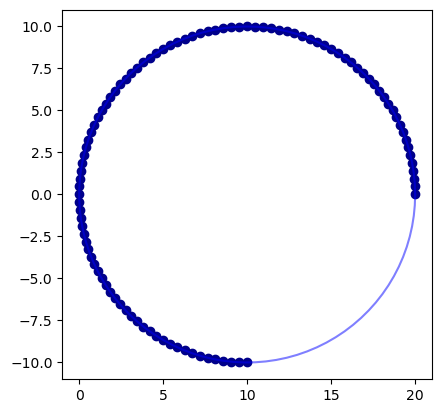

In [11]:
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(circle_x,circle_y,color="blue",alpha=0.5)
plt.scatter(growth_front_0[0,:],growth_front_0[1,:],color="darkblue")

Structure

<blockquote>

growth_front_0: 'growth' working array (numpy) corresponds to the successive growth fronts
- shape[1]: number of points on the front
- shape[0]: followed variables

|       |           [:,i] front points                                    |
|-------|-----------------------------------------------------------------|    
| [0,:] | x axis coordinates                                              |
| [1,:] | y axis coordinates                                              |
| [2,:] | distance to previous point                                      |
| [3,:] | u growth vector parameter                                       |
| [4,:] | v growth vector parameter                                       |
| [5,:] | if ==1 this points was added at the last iteration              |
| [6,:] | curvature                                                       |
    
    
successives growth_front will be subsequently in list_growth_front
  
</blockquote> 

#### Distance between two points of the front

In [12]:
def distance_array(growth_front):
    growth_front[2,0]=0
    for j in range(1,growth_front.shape[1]):
        growth_front[2,j]=math.sqrt((growth_front[0,j]-growth_front[0,j-1])**2+(growth_front[1,j]-growth_front[1,j-1])**2)  
    return(growth_front)

In [13]:
growth_front_0_dist=distance_array(growth_front_0)

In [14]:
print(np.median(growth_front_0_dist[2,:]))

0.47595395092214987


#### Insert Point

In [15]:
def insert_points(growth_front,max_res=MAX_RES):     #critical distance is two times the median distance for the initial front
    if growth_front.shape[1]<10000:
        insert=np.nonzero(growth_front[2,:]>max_res)[0]
        growth_front[5,:]=0
        if len(insert) != 0:
            col=np.zeros((growth_front.shape[0],len(insert)))
            for j in range(0,len(insert)):
                col[0,j]=(growth_front[0,insert[j]]+growth_front[0,insert[j]-1])/2
                col[1,j]=(growth_front[1,insert[j]]+growth_front[1,insert[j]-1])/2
                col[5,j]=1
            growth_front=np.insert(growth_front,insert[:],col,axis=1)

    return(growth_front)


#### Delete points

point by point

In [16]:
def delete_points(growth_front,min_res=MIN_RES):
    delete=np.nonzero(growth_front[2,:]<min_res)[0]
    
    while len(delete)>1:  #reminder: after a test, you showed you were deleting too many points if using directly np.delete
        growth_front=np.delete(growth_front,delete[1],axis=1)
        growth_front=distance_array(growth_front)
        delete=np.nonzero((growth_front[2,:]<MIN_RES))[0] #delete point by point
    
    return(growth_front)

#### Normal Vector

In [17]:
def vecteur_normal(growth_front): 
    #first point
    growth_front[3,0]=growth_front[1,1]-growth_front[1,0]     #u
    growth_front[4,0]=-growth_front[0,1]+growth_front[0,0]    #v
    Lo=math.sqrt(growth_front[3,0]**2+growth_front[4,0]**2)
    growth_front[3,0]=growth_front[3,0]/Lo
    growth_front[4,0]=growth_front[4,0]/Lo
    
    #front Loop
    for j in range(1,growth_front.shape[1]-1):
            growth_front[3,j]=(growth_front[1,j+1]-growth_front[1,j-1])/2           #have to divide the distance by two
            growth_front[4,j]=(-growth_front[0,j+1]+growth_front[0,j-1])/2
            Lo=math.sqrt(growth_front[3,j]**2+growth_front[4,j]**2)    
            growth_front[3,j]=growth_front[3,j]/Lo
            growth_front[4,j]=growth_front[4,j]/Lo     
            
    #Last point
    growth_front[3,-1]=growth_front[1,-1]-growth_front[1,-2]
    growth_front[4,-1]=-growth_front[0,-1]+growth_front[0,-2]
    Lo=math.sqrt(growth_front[3,-1]**2+growth_front[4,-1]**2)
    growth_front[3,-1]=growth_front[3,-1]/Lo
    growth_front[4,-1]=growth_front[4,-1]/Lo
    return(growth_front)

#### Curvature

In [18]:
def curvature_biased(growth_front):     #à répaparer ?
    #first point
    u_1=growth_front[3,0]
    v_1=growth_front[4,0]
    u_2=growth_front[3,1]
    v_2=growth_front[4,1]
    d=growth_front[2,1]+growth_front[2,0]
    growth_front[6,0]=math.asin(u_1*v_2-u_2*v_1)/d
    
    
    #loop
    for j in range(1,growth_front.shape[1]-1):
        u_1=growth_front[3,j-1]
        v_1=growth_front[4,j-1]
        u_2=growth_front[3,j+1]
        v_2=growth_front[4,j+1]
        d=growth_front[2,j+1]+growth_front[2,j]
        growth_front[6,j]=math.asin(u_1*v_2-u_2*v_1)/d
    
    
    #last point
    v_1=growth_front[3,-1]
    u_1=growth_front[4,-1]
    v_2=growth_front[3,-2]
    u_2=growth_front[4,-2]
    d=growth_front[2,-1]
    growth_front[6,-1]=math.asin(u_1*v_2-u_2*v_1)/d    
    
    return(growth_front)

In [19]:
def curvature_corrected(growth_front):     #à réparer ?
    
    
    # first point
    u_1=growth_front[3,0]
    v_1=growth_front[4,0]
    u_2=growth_front[3,1]
    v_2=growth_front[4,1]
    corr=1/2
    d=growth_front[2,1]*corr
    growth_front[6,0]=math.asin(u_1*v_2-u_2*v_1)/d
    
    # second point
    u_1=growth_front[3,0]
    v_1=growth_front[4,0]
    u_2=growth_front[3,2]
    v_2=growth_front[4,2]
    corr=3/4
    d=(growth_front[2,1]+growth_front[2,2])*corr
    growth_front[6,1]=math.asin(u_1*v_2-u_2*v_1)/d    
    
    
    # loop     
    for j in range(2,growth_front.shape[1]-2):
        u_1=growth_front[3,j-1]
        v_1=growth_front[4,j-1]
        u_2=growth_front[3,j+1]
        v_2=growth_front[4,j+1]
        d=growth_front[2,j+1]+growth_front[2,j]             
        growth_front[6,j]=math.asin(u_1*v_2-u_2*v_1)/d
    
    # first before last
    u_1=growth_front[3,-3]
    v_1=growth_front[4,-3]
    u_2=growth_front[3,-1]
    v_2=growth_front[4,-1]
    corr=3/4
    d=(growth_front[2,-1]+growth_front[2,-2])*corr
    growth_front[6,-2]=math.asin(u_1*v_2-u_2*v_1)/d  
    
    # last point
    v_1=growth_front[3,-1]
    u_1=growth_front[4,-1]
    v_2=growth_front[3,-2]
    u_2=growth_front[4,-2]
    corr=1/2
    d=growth_front[2,-1]*corr
    growth_front[6,-1]=math.asin(u_1*v_2-u_2*v_1)/d 
    
    
    return(growth_front)

Test

In [20]:
growth_front_0=initial_array_arc()
growth_front_0=distance_array(growth_front_0)
growth_front_0=vecteur_normal(growth_front_0)
growth_front_0=curvature_corrected(growth_front_0)

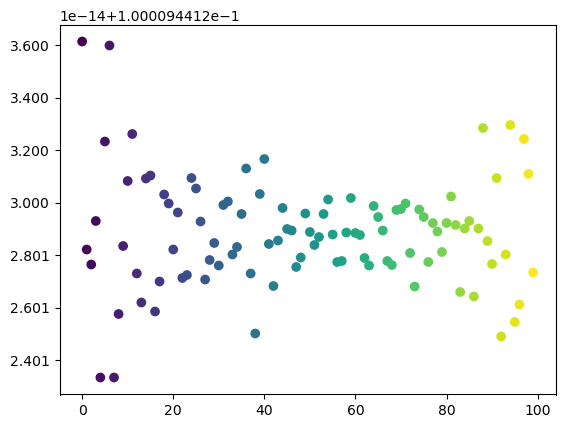

In [21]:
growth_front_0[6,:]
d=R*2/NB_POINTS_0
window=5 
dt=0.1
c=uniform_filter1d(growth_front_0[6,:], size=window,mode='reflect')        
A_L=0.5*(1+d*c)*dt
t=range(len(c))
#plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(range(len(c)),y=growth_front_0[6,:],c=t)

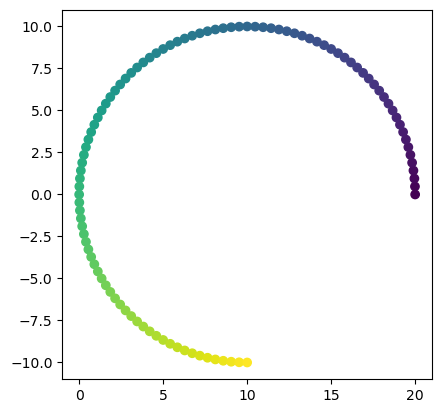

In [22]:
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(growth_front_0[0,:],growth_front_0[1,:],c=t)


In [23]:
print(growth_front_0)

[[ 2.00000000e+01  1.99886734e+01  1.99547192e+01  1.98982144e+01
   1.98192870e+01  1.97181157e+01  1.95949297e+01  1.94500082e+01
   1.92836793e+01  1.90963200e+01  1.88883545e+01  1.86602540e+01
   1.84125353e+01  1.81457595e+01  1.78605309e+01  1.75574957e+01
   1.72373404e+01  1.69007901e+01  1.65486073e+01  1.61815899e+01
   1.58005691e+01  1.54064082e+01  1.50000000e+01  1.45822652e+01
   1.41541501e+01  1.37166246e+01  1.32706796e+01  1.28173256e+01
   1.23575894e+01  1.18925124e+01  1.14231484e+01  1.09505604e+01
   1.04758192e+01  1.00000000e+01  9.52418084e+00  9.04943957e+00
   8.57685162e+00  8.10748756e+00  7.64241064e+00  7.18267443e+00
   6.72932037e+00  6.28337544e+00  5.84584987e+00  5.41773478e+00
   5.00000000e+00  4.59359183e+00  4.19943090e+00  3.81841014e+00
   3.45139266e+00  3.09920989e+00  2.76265962e+00  2.44250426e+00
   2.13946905e+00  1.85424048e+00  1.58746467e+00  1.33974596e+00
   1.11164551e+00  9.03680046e-01  7.16320670e-01  5.49991813e-01
   4.05070

#### Front Growth

In [24]:
def growth_frond_const(growth_front):
    gf_deepcopy = deepcopy(growth_front) 
    for j in range(0,growth_front.shape[1]):
        A_L=0.2
        gf_deepcopy[0,j]=gf_deepcopy[0,j]+A_L*growth_front[3,j]
        gf_deepcopy[1,j]=gf_deepcopy[1,j]+A_L*growth_front[4,j]
    return(gf_deepcopy)

In [25]:
def growth_frond_wound(growth_front,r=R):
    
    # copy growth front
    gf_deepcopy = deepcopy(growth_front) 
    
    # borders
    gf_deepcopy[0,0]=gf_deepcopy[0,0]
    gf_deepcopy[1,0]=gf_deepcopy[1,0]
    gf_deepcopy[0,-1]=gf_deepcopy[0,-1]
    gf_deepcopy[1,-1]=gf_deepcopy[1,-1]
    
    # bulk
    for j in range(1,growth_front.shape[1]-1):
        if (gf_deepcopy[0,j]-r)**2+gf_deepcopy[1,j]**2<(r-r/100)**2:     #there is an error margin for the starting point 
            A_L=0                                                         #instead of r**2
        else:
            A_L=0.5
        gf_deepcopy[0,j]=gf_deepcopy[0,j]+A_L*growth_front[3,j]
        gf_deepcopy[1,j]=gf_deepcopy[1,j]+A_L*growth_front[4,j]
    return(gf_deepcopy)

In [26]:
def growth_frond_wound_curvature(growth_front,r=R,nb_points_0=NB_POINTS_0,dt=DT):
    
    # copy growth front
    gf_deepcopy = deepcopy(growth_front) 
    
    # borders
    gf_deepcopy[0,0]=gf_deepcopy[0,0]
    gf_deepcopy[1,0]=gf_deepcopy[1,0]
    gf_deepcopy[0,-1]=gf_deepcopy[0,-1]
    gf_deepcopy[1,-1]=gf_deepcopy[1,-1]
    
    
    # bulk
    d=r*2/nb_points_0
    window=3 
    dt=0.01
    c=uniform_filter1d(gf_deepcopy[6,:], size=window,mode='reflect')        
    A_L=0.5*(1+d*c*100)*dt
    A_L[0]=0
    A_L[-1]=0
    for j in range(1,growth_front.shape[1]-1):             
        if (gf_deepcopy[0,j]-r)**2+gf_deepcopy[1,j]**2<(r-r/100)**2:     #there is an error margin for the starting point 
            A_L[j]=0   
            
    A_L=np.array(A_L)
        
    gf_deepcopy[0,:]=gf_deepcopy[0,:]+A_L*growth_front[3,:]
    gf_deepcopy[1,:]=gf_deepcopy[1,:]+A_L*growth_front[4,:]
    
    return(gf_deepcopy)

In [27]:
def growth_frond_wound_gradient(growth_front,r=R):
    
    # copy growth front
    gf_deepcopy = deepcopy(growth_front) 
    
    # borders
    gf_deepcopy[0,0]=gf_deepcopy[0,0]
    gf_deepcopy[1,0]=gf_deepcopy[1,0]
    gf_deepcopy[0,-1]=gf_deepcopy[0,-1]
    gf_deepcopy[1,-1]=gf_deepcopy[1,-1]
    
    # bulk
    for j in range(1,growth_front.shape[1]-1):
        if (gf_deepcopy[0,j]-r)**2+gf_deepcopy[1,j]**2<(r-r/100)**2:     #there is an error margin for the starting point 
            A_L=0                                                         #instead of r**2
        else:
            A_L=0.5
        gf_deepcopy[0,j]=gf_deepcopy[0,j]+A_L*growth_front[3,j]
        gf_deepcopy[1,j]=gf_deepcopy[1,j]+A_L*growth_front[4,j]
    return(gf_deepcopy)

#### Loop removal

In [28]:

def loop_removal(old_front,new_front,distmin=DIST_MIN):
    
     #create matrix with x and y coordinates
    old_mat=np.array([old_front[0,:],old_front[1,:]])
    new_mat=np.array([new_front[0,:],new_front[1,:]])
    
    # compute the list of distance bewteen a point and itself at t+1, find max spread to consider
    spread_list=np.sqrt(np.sum((new_mat-old_mat)**2,axis=0))
    max_spread=max(spread_list)
    neighbours=math.ceil(2*max_spread/distmin)
    
    
    # create and fill distance matrice, lines: (size 2*neighbours+1), columns: (number of points columns)
    # each lines correspond to the distance between all the points of the front and the neighbour k
    dist_mat=np.zeros((2*neighbours+1,np.shape(new_mat)[1]))
    for k in range(-neighbours,neighbours+1):
        old_mat_rolled=np.roll(old_mat,k)
        dist_mat[neighbours+k]=np.sqrt(np.sum((new_mat-old_mat_rolled)**2,axis=0))
    
    # delete a point of the new front if there is 
    # at least one point for which the distance is inferior to the spread of the point
    ind_toremove=np.unique((dist_mat<spread_list[None,:]).nonzero()[1])
    
    cleaned_front=np.delete(new_front,ind_toremove,axis=1)
    
    return(cleaned_front)

<hr style="border:2px solid gray"> </hr>

# Test growth front wound

In [29]:
## INITIALIZE

###define initial array
growth_front_0=initial_array_arc()
growth_front_0=distance_array(growth_front_0)
growth_front_0=vecteur_normal(growth_front_0)
growth_front_0=curvature_corrected(growth_front_0)


###create empty list to save future arrays
list_growth_front_wound=[]
list_growth_front_wound.append(growth_front_0)

###set time list
current_time=0
list_time=[current_time]



## MAIN LOOP
for i,current_time in enumerate(TIME):  
    list_time.append(current_time)

    #print(i,len(time))

    # Initialize (we copy the previous array to modify)
    previous_front=np.array(list_growth_front_wound[i-1])

    #Growth 
    new_front=np.array(growth_frond_wound(previous_front))
    
    #loop ablation
    new_front=loop_removal(previous_front,new_front)

    #Compute Distances    
    new_front=distance_array(new_front)

    #delete points
    new_front=delete_points(new_front)

    #Compute distances again       
    new_front=distance_array(new_front)

    #insert points
    new_front=insert_points(new_front)
    
    #Compute distances again       
    new_front=distance_array(new_front)
    
    #Compute normal vector
    new_front=vecteur_normal(new_front)
    
    #Compute curvature
    new_front=curvature_corrected(new_front)

    #Troubleshooting
    if 0:
        plt.figure()
        plt.plot(previous_front[0,:],previous_front[1,:],'+')
        plt.plot(new_front[0,:],new_front[1,:],'s')
        plt.show()
        input()
    list_growth_front_wound.append(new_front)    

    ### BREAK THE LOOP

    if i%10==0: 
        print('i',i,current_time)

    if i>=IMAX:
        print('BREAK AT TIME:', current_time , 'ITERATION:', i )
        break


i 0 0
i 10 10
i 20 20
i 30 30
i 40 40
i 50 50
i 60 60
i 70 70
i 80 80
i 90 90
i 100 100
BREAK AT TIME: 100 ITERATION: 100


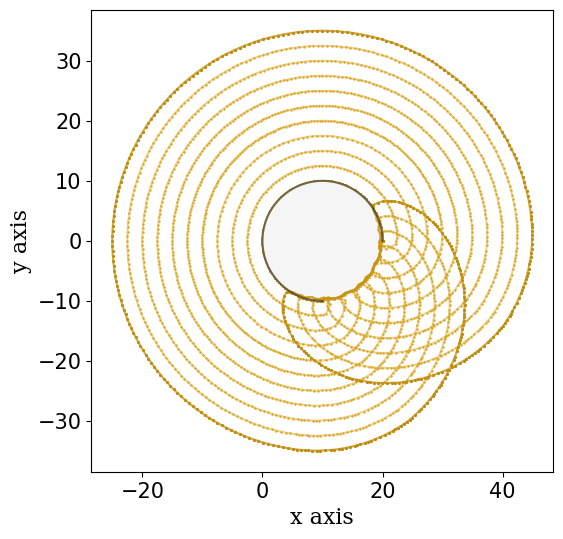

In [104]:
#                                                 INITIATE
%matplotlib inline
fig_leaf, ax = plt.subplots(figsize=(6,6))
#plt.grid(True)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('x axis', fontsize = 16, fontfamily='serif')
plt.ylabel('y axis', fontsize = 16, fontfamily='serif')

#                                               GROWTH FRONT

                                         # CURVATURE FRONT
# Create color map
cividis = cm.get_cmap('cividis', 50)
# Emphase
for growth_front in list_growth_front_wound[::int(IMAX/10)]:
    n_point=growth_front.shape[1]

    x=growth_front[0,:]
    y=growth_front[1,:]
    cividis_value=growth_front[6,:]/max(growth_front[6,:])
    plt.plot(x,y,color='goldenrod',alpha=0.5)
    plt.scatter(x,y,color='goldenrod',s=0.5)
    
    
# all points
#for growth_front in list_growth_front_wound:
    #n_point=growth_front.shape[1]

    #x=growth_front[0,:]
    #y=growth_front[1,:]
    #cividis_value=growth_front[6,:]/max(growth_front[6,:])
    #plt.scatter(x,y,color='palegoldenrod',s=0.5)
    
#last line
data = list_growth_front_wound[-1]
x=growth_front[0,:]
y=growth_front[1,:]
cividis_value=growth_front[6,:]/max(growth_front[6,:])
plt.scatter(x,y,color='darkgoldenrod',s=1.5)
plt.plot(x,y,color='darkgoldenrod',alpha=0.5)

# first line
#Number of printed successives fronts
data = list_growth_front_wound[0]
x=data[0,:]
y=data[1,:]
u=data[2,:]
v=data[3,:]
cividis_value=data[6,:]/max(data[6,:])
#plt.scatter(x,y,color=cividis(cividis_value),s=3)
plt.scatter(x,y,color='darkgoldenrod',s=1.5)

# initial circle
theta_circle=np.linspace(0,3*np.pi/2,NB_POINTS_0)
circle_x = R*(1+np.cos(theta_circle))
circle_y= R*np.sin(theta_circle)
plt.plot(circle_x,circle_y,color="black",alpha=0.5)

circle1 = plt.Circle((R, 0), R, color='whitesmoke')
ax.add_patch(circle1)

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)


plt.savefig('cambium_overlap.pdf')   
plt.show()


<hr style="border:2px solid gray"> </hr>

# Test Obstacle

In [31]:
## INITIALIZE

###define initial array
growth_front_0=initial_array_arc()
growth_front_0=distance_array(growth_front_0)
growth_front_0=vecteur_normal(growth_front_0)
growth_front_0=curvature_corrected(growth_front_0)


###create empty list to save future arrays
list_growth_front_obtest=[]
list_growth_front_obtest.append(growth_front_0)

###set time list
current_time=0
list_time=[current_time]



## MAIN LOOP
for i,current_time in enumerate(TIME):  
    list_time.append(current_time)

    #print(i,len(time))

    # Initialize (we copy the previous array to modify)
    previous_front=np.array(list_growth_front_obtest[i-1])

    #Growth 
    new_front=np.array(growth_frond_wound(previous_front))
    
    #loop ablation
    new_front=loop_removal(previous_front,new_front)

    #Compute Distances    
    new_front=distance_array(new_front)

    #delete points
    if i<30:
        new_front=delete_points(new_front)

    #Compute distances again       
    new_front=distance_array(new_front)

    #insert points
    if i<30:
        new_front=insert_points(new_front)
    
    #Compute distances again       
    new_front=distance_array(new_front)
    
    #Compute normal vector
    new_front=vecteur_normal(new_front)
    
    #Compute curvature
    new_front=curvature_corrected(new_front)

    #Troubleshooting
    if 0:
        plt.figure()
        plt.plot(previous_front[0,:],previous_front[1,:],'+')
        plt.plot(new_front[0,:],new_front[1,:],'s')
        plt.show()
        input()
    list_growth_front_obtest.append(new_front)    

    ### BREAK THE LOOP

    if i%10==0: 
        print('i',i,current_time)

    if i>=IMAX:
        print('BREAK AT TIME:', current_time , 'ITERATION:', i )
        break


i 0 0
i 10 10
i 20 20
i 30 30
i 40 40
i 50 50
i 60 60
i 70 70
i 80 80
i 90 90
i 100 100
BREAK AT TIME: 100 ITERATION: 100


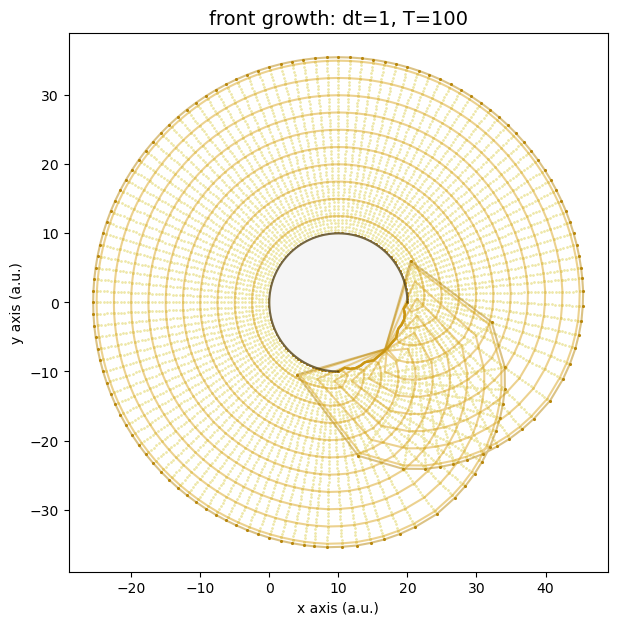

In [32]:
#                                                 INITIATE
%matplotlib inline
fig_leaf, ax = plt.subplots(figsize=(7,7))
#plt.grid(True)

title = "front growth: dt={}, T={}".format(DT,IMAX) 
plt.title(title, fontsize=14)
plt.gca().set_aspect('equal', adjustable='box')
ax.set(xlabel='x axis (a.u.)', ylabel='y axis (a.u.)')

#                                               GROWTH FRONT

                                         # CURVATURE FRONT
# Create color map
cividis = cm.get_cmap('cividis', 50)
# Emphase
for growth_front in list_growth_front_obtest[::int(IMAX/10)]:
    n_point=growth_front.shape[1]

    x=growth_front[0,:]
    y=growth_front[1,:]
    cividis_value=growth_front[6,:]/max(growth_front[6,:])
    plt.plot(x,y,color='goldenrod',alpha=0.5)
    plt.scatter(x,y,color='goldenrod',s=0.5)
    
    
# all points
for growth_front in list_growth_front_obtest:
    n_point=growth_front.shape[1]

    x=growth_front[0,:]
    y=growth_front[1,:]
    cividis_value=growth_front[6,:]/max(growth_front[6,:])
    plt.scatter(x,y,color='palegoldenrod',s=0.5)
    
#last line
data = list_growth_front_obtest[-1]
x=growth_front[0,:]
y=growth_front[1,:]
cividis_value=growth_front[6,:]/max(growth_front[6,:])
plt.scatter(x,y,color='darkgoldenrod',s=1.5)
plt.plot(x,y,color='darkgoldenrod',alpha=0.5)

# first line
#Number of printed successives fronts
data = list_growth_front_obtest[0]
x=data[0,:]
y=data[1,:]
u=data[2,:]
v=data[3,:]
cividis_value=data[6,:]/max(data[6,:])
#plt.scatter(x,y,color=cividis(cividis_value),s=3)
plt.scatter(x,y,color='darkgoldenrod',s=1.5)

# initial circle
theta_circle=np.linspace(0,3*np.pi/2,NB_POINTS_0)
circle_x = R*(1+np.cos(theta_circle))
circle_y= R*np.sin(theta_circle)
plt.plot(circle_x,circle_y,color="black",alpha=0.5)

circle1 = plt.Circle((R, 0), R, color='whitesmoke')
ax.add_patch(circle1)


plt.savefig('Blessure_Cambium_test obstacle.jpg')   
plt.show()


In [33]:
np.save('pre_loop',list_growth_front_obtest[31])
np.save('post_loop',list_growth_front_obtest[55])

In [34]:
def angle_pol(x_old,y_old,x_new,y_new,ind):
    
    # INSIDE POINT COORDINATES
    x_ins = x_new[ind]
    y_ins = y_new[ind]

    ## SUM OF ANGLES

    # loop angles
    sum_angle=0
    for i in range(len(x_old)):
        if i == len(x_old)-1:
            vector1_x  = x_old[i] - x_ins
            vector1_y = y_old[i] - y_ins

            vector2_x = x_old[0] - x_ins
            vector2_y = y_old[0] - y_ins

            angle = math.atan2( vector1_x*vector2_y - vector1_y*vector2_x, vector1_x*vector2_x + vector1_y*vector2_y)
            sum_angle += angle
        else: 
            vector1_x = x_old[i] - x_ins
            vector1_y = y_old[i] - y_ins

            vector2_x = x_old[i+1] - x_ins
            vector2_y = y_old[i+1] - y_ins

            angle = math.atan2( vector1_x*vector2_y - vector1_y*vector2_x, vector1_x*vector2_x + vector1_y*vector2_y)
            sum_angle += angle
 
    return(sum_angle/math.pi)

In [35]:
x_old = list_growth_front_wound[31][0,:]
y_old = list_growth_front_wound[31][1,:]
x_new = list_growth_front_wound[55][0,:]
y_new = list_growth_front_wound[55][1,:]
ind_ins=10
angle_ins=angle_pol(x_old,y_old,x_new,y_new,ind_ins)
ind_out=80
angle_out=angle_pol(x_old,y_old,x_new,y_new,ind_out)

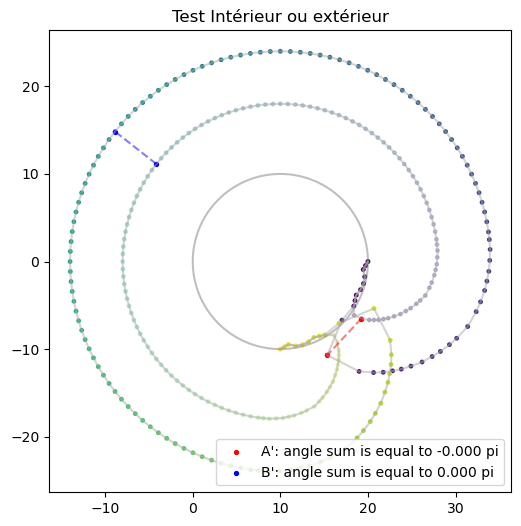

In [36]:
%matplotlib inline
fig_leaf, ax = plt.subplots(figsize=(6,6))
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Test Intérieur ou extérieur")

#initial circle
theta_circle=np.linspace(0,2*np.pi,NB_POINTS_0)
circle_x = R*(1+np.cos(theta_circle))
circle_y= R*np.sin(theta_circle)
plt.plot(circle_x,circle_y,color="grey",alpha=0.5)

#one before loop
data = list_growth_front_obtest[31]
x = data[0,:]
y = data[1,:]
ind = range(len(x))
plt.scatter(x,y,c=ind,s=6,alpha=0.3)
plt.plot(x,y,color='darkgrey',alpha=0.5)

#Last with loop
data = list_growth_front_obtest[55]
x = data[0,:]
y = data[1,:]
ind = range(len(x))
plt.scatter(x,y,c=ind,s=6,alpha=1)
plt.plot(x,y,color='darkgrey',alpha=0.5)

plt.scatter(list_growth_front_obtest[31][0,10],list_growth_front_obtest[31][1,10],color='red',s=8)
plt.scatter(list_growth_front_obtest[55][0,10],list_growth_front_obtest[55][1,10],color='red',s=8,label=f'A\': angle sum is equal to {angle_ins:.3f} pi')
plt.plot([list_growth_front_obtest[31][0,10],list_growth_front_obtest[55][0,10]],[list_growth_front_obtest[31][1,10],list_growth_front_obtest[55][1,10]],color='red',alpha=0.5,linestyle='--')

plt.scatter(list_growth_front_obtest[31][0,80],list_growth_front_obtest[31][1,80],color='blue',s=8)
plt.scatter(list_growth_front_obtest[55][0,80],list_growth_front_obtest[55][1,80],color='blue',s=8,label=f'B\': angle sum is equal to {angle_out:.3f} pi')
plt.plot([list_growth_front_obtest[31][0,80],list_growth_front_obtest[55][0,80]],[list_growth_front_obtest[31][1,80],list_growth_front_obtest[55][1,80]],color='blue',alpha=0.5,linestyle='--')


ax.legend()
plt.show()

In [37]:
x_old = list_growth_front_wound[31][0,:]
y_old = list_growth_front_wound[31][1,:]
x_new = list_growth_front_wound[55][0,:]
y_new = list_growth_front_wound[55][1,:]
ind_ins=20
angle_ins=angle_pol(x_old,y_old,x_new,y_new,ind_ins)
ind_out=200
angle_out=angle_pol(x_old,y_old,x_new,y_new,ind_out)
print(angle_out)

-7.067899292141149e-17


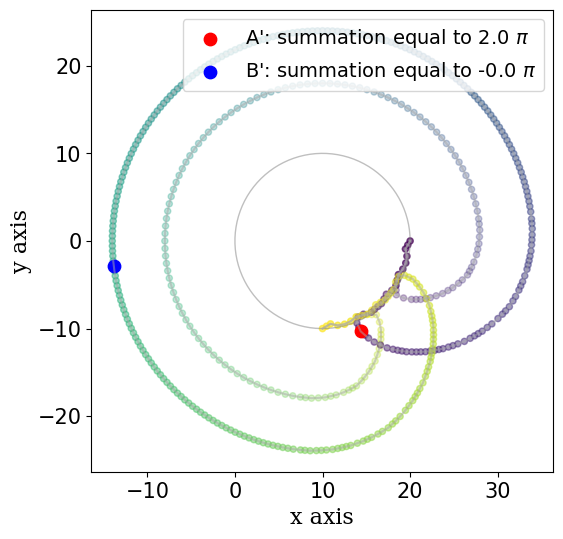

In [99]:
%matplotlib inline
fig_leaf, ax = plt.subplots(figsize=(6,6))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('x axis', fontsize = 16, fontfamily='serif')
plt.ylabel('y axis', fontsize = 16, fontfamily='serif')

#initial circle
theta_circle=np.linspace(0,2*np.pi,NB_POINTS_0)
circle_x = R*(1+np.cos(theta_circle))
circle_y= R*np.sin(theta_circle)
plt.plot(circle_x,circle_y,color="grey",alpha=0.5, linewidth = 1)

#one before loop
data_bef = list_growth_front_wound[31]
x_bef = data_bef[0,:]
y_bef = data_bef[1,:]
ind_bef = range(len(x_bef))
plt.scatter(x_bef,y_bef,c=ind_bef,s=20,alpha=0.3)
plt.plot(x_bef,y_bef,color='darkgrey',alpha=0.5)

#Last with loop
data_last = list_growth_front_wound[55]
x_last = data_last[0,:]
y_last = data_last[1,:]
ind_last= range(len(x_last))
plt.scatter(x_last,y_last,c=ind_last,s=20,alpha=0.5)
plt.plot(x_last,y_last,color='darkgrey',alpha=0.5)

plt.scatter(list_growth_front_wound[55][0,20],list_growth_front_wound[55][1,20],color='red',s=80,label=f'A\': summation equal to {angle_ins:.1f} $\pi$')

plt.scatter(list_growth_front_wound[55][0,200],list_growth_front_wound[55][1,200],color='blue',s=80,label=f'B\': summation equal to {angle_out:.1f} $\pi$')

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

ax.legend(loc='upper right', fontsize = 14)
plt.savefig('Inside_or_Outside.pdf') 
#plt.show()

# Test growth front obstacle

In [39]:
def growth_frond_obstacle(old_front,r=R):
    
    # copy growth front
    new_front = deepcopy(old_front) 
    
    # bulk (borders are at 0)
    for i in range(1,old_front.shape[1]-1):  
        # IN THE CIRCLE
        if (new_front[0,i]-r)**2+new_front[1,i]**2<(r-r/100)**2:     #there is an error margin for the starting point 
            A_L=0                                                         #instead of r**2
        # OUTSIDE THE CIRCLE
        else:
            A_L=0.5
        new_front[0,i]=new_front[0,i]+A_L*old_front[3,i]
        new_front[1,i]=new_front[1,i]+A_L*old_front[4,i]
        
    # find overlap and restore
    for i in range(1,old_front.shape[1]-1):
        angle_i=angle_pol(old_front[0,:],old_front[1,:],new_front[0,:],new_front[1,:],i)
        if (angle_i > 0.1) or (angle_i < -0.1):
            new_front[0,i]=old_front[0,i]
            new_front[1,i]=old_front[1,i]

    return(new_front)

In [40]:
## INITIALIZE

###define initial array
growth_front_0=initial_array_arc()
growth_front_0=distance_array(growth_front_0)
growth_front_0=vecteur_normal(growth_front_0)
growth_front_0=curvature_corrected(growth_front_0)


###create empty list to save future arrays
list_growth_front_obtest=[]
list_growth_front_obtest.append(growth_front_0)

###set time list
current_time=0
list_time=[current_time]



## MAIN LOOP
for i,current_time in enumerate(TIME):  
    list_time.append(current_time)

    #print(i,len(time))

    # Initialize (we copy the previous array to modify)
    previous_front=np.array(list_growth_front_obtest[i-1])

    #Growth 
    new_front=np.array(growth_frond_obstacle(previous_front))
    
    #loop ablation
    new_front=loop_removal(previous_front,new_front)

    #Compute Distances    
    new_front=distance_array(new_front)

    #delete points
    new_front=delete_points(new_front)

    #Compute distances again       
    new_front=distance_array(new_front)

    #insert points
    new_front=insert_points(new_front)
    
    #Compute distances again       
    new_front=distance_array(new_front)
    
    #Compute normal vector
    new_front=vecteur_normal(new_front)
    
    #Compute curvature
    new_front=curvature_corrected(new_front)

    #Troubleshooting
    if 0:
        plt.figure()
        plt.plot(previous_front[0,:],previous_front[1,:],'+')
        plt.plot(new_front[0,:],new_front[1,:],'s')
        plt.show()
        input()
    list_growth_front_obtest.append(new_front)    

    ### BREAK THE LOOP

    if i%10==0: 
        print('i',i,current_time)

    if i>=IMAX:
        print('BREAK AT TIME:', current_time , 'ITERATION:', i )
        break


i 0 0
i 10 10
i 20 20
i 30 30
i 40 40
i 50 50
i 60 60
i 70 70
i 80 80
i 90 90
i 100 100
BREAK AT TIME: 100 ITERATION: 100


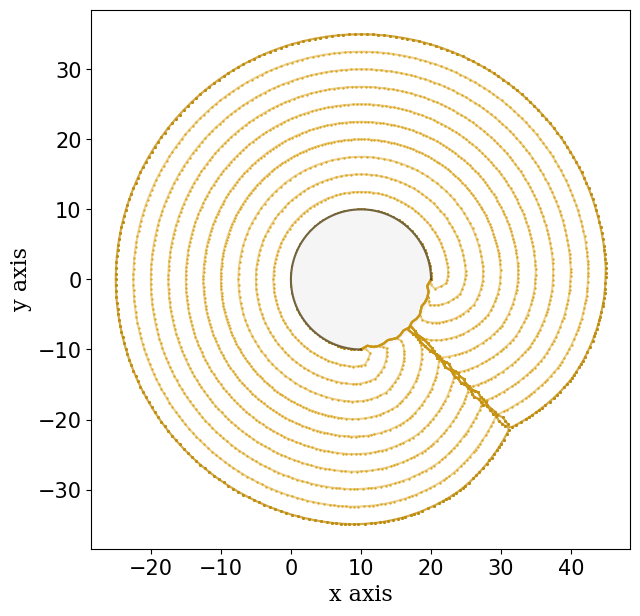

In [105]:
#                                                 INITIATE
%matplotlib inline
fig_leaf, ax = plt.subplots(figsize=(7,7))
#plt.grid(True)

#title = "front growth: dt={}, T={}".format(DT,IMAX) 
#plt.title(title, fontsize=14)
plt.gca().set_aspect('equal', adjustable='box')
#plt.xlim(-20, 40)
#plt.ylim(-30, 30)
ax.set(xlabel='x axis (a.u.)', ylabel='y axis (a.u.)')

plt.xlabel('x axis', fontsize = 16, fontfamily='serif')
plt.ylabel('y axis', fontsize = 16, fontfamily='serif')

#                                               GROWTH FRONT

                                         # CURVATURE FRONT
# Create color map
cividis = cm.get_cmap('cividis', 50)
# Emphase
for growth_front in list_growth_front_obtest[::int(IMAX/10)]:
    n_point=growth_front.shape[1]

    x=growth_front[0,:]
    y=growth_front[1,:]
    cividis_value=growth_front[6,:]/max(growth_front[6,:])
    plt.plot(x,y,color='goldenrod',alpha=0.5)
    plt.scatter(x,y,color='goldenrod',s=0.5)
    
    
# all points
#for growth_front in list_growth_front_obtest:
    #n_point=growth_front.shape[1]

    #x=growth_front[0,:]
    #y=growth_front[1,:]
    #cividis_value=growth_front[6,:]/max(growth_front[6,:])
    #plt.scatter(x,y,color='palegoldenrod',s=0.5)
    
#last line
data = list_growth_front_obtest[-1]
x=growth_front[0,:]
y=growth_front[1,:]
cividis_value=growth_front[6,:]/max(growth_front[6,:])
plt.scatter(x,y,color='darkgoldenrod',s=1.5)
plt.plot(x,y,color='darkgoldenrod',alpha=0.5)

# first line
#Number of printed successives fronts
data = list_growth_front_obtest[0]
x=data[0,:]
y=data[1,:]
u=data[2,:]
v=data[3,:]
cividis_value=data[6,:]/max(data[6,:])
#plt.scatter(x,y,color=cividis(cividis_value),s=3)
plt.scatter(x,y,color='darkgoldenrod',s=1.5)

# initial circle
theta_circle=np.linspace(0,3*np.pi/2,NB_POINTS_0)
circle_x = R*(1+np.cos(theta_circle))
circle_y= R*np.sin(theta_circle)
plt.plot(circle_x,circle_y,color="black",alpha=0.5)

circle1 = plt.Circle((R, 0), R, color='whitesmoke')
ax.add_patch(circle1)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
plt.savefig('Cambium_postablation.pdf')   
plt.show()


<hr style="border:2px solid gray"> </hr>

# Test growth front curvature

In [42]:
## INITIALIZE

###define initial array
growth_front_0=initial_array_arc()
growth_front_0=distance_array(growth_front_0)
growth_front_0=vecteur_normal(growth_front_0)
growth_front_0=curvature_corrected(growth_front_0)


###create empty list to save future arrays
list_growth_front_curv=[]
list_growth_front_curv.append(growth_front_0)

###set time list
current_time=0
list_time=[current_time]



## MAIN LOOP
for i,current_time in enumerate(TIME):  
    list_time.append(current_time)

    #print(i,len(time))

    # Initialize (we copy the previous array to modify)
    previous_front=np.array(list_growth_front_obtest[i-1])

    #Growth 
    new_front=np.array(growth_frond_wound_curvature(previous_front))
    
    #loop ablation
    new_front=loop_removal(previous_front,new_front)

    #Compute Distances    
    new_front=distance_array(new_front)

    #delete points
    new_front=delete_points(new_front)

    #Compute distances again       
    new_front=distance_array(new_front)

    #insert points
    new_front=insert_points(new_front)
    
    #Compute distances again       
    new_front=distance_array(new_front)
    
    #Compute normal vector
    new_front=vecteur_normal(new_front)
    
    #Compute curvature
    new_front=curvature_corrected(new_front)

    #Troubleshooting
    if 0:
        plt.figure()
        plt.plot(previous_front[0,:],previous_front[1,:],'+')
        plt.plot(new_front[0,:],new_front[1,:],'s')
        plt.show()
        input()
    list_growth_front_curv.append(new_front)    

    ### BREAK THE LOOP

    if i%10==0: 
        print('i',i,current_time)

    if i>=IMAX:
        print('BREAK AT TIME:', current_time , 'ITERATION:', i )
        break


i 0 0
i 10 10
i 20 20
i 30 30
i 40 40
i 50 50
i 60 60
i 70 70
i 80 80
i 90 90
i 100 100
BREAK AT TIME: 100 ITERATION: 100


In [43]:
#                                                 INITIATE
%matplotlib qt
fig_leaf, ax = plt.subplots(figsize=(7,7))
#plt.grid(True)

title = "front growth: dt={}, T={}".format(DT,IMAX) 
plt.title(title, fontsize=14)
plt.gca().set_aspect('equal', adjustable='box')
ax.set(xlabel='x axis (a.u.)', ylabel='y axis (a.u.)')

#                                               GROWTH FRONT

                                         # CURVATURE FRONT
# Create color map
cividis = cm.get_cmap('cividis', 50)
# Emphase
for growth_front in list_growth_front_curv[::int(IMAX/10)]:
    n_point=growth_front.shape[1]

    x=growth_front[0,:]
    y=growth_front[1,:]
    cividis_value=growth_front[6,:]/max(growth_front[6,:])
    plt.plot(x,y,color='goldenrod',alpha=0.5)
    plt.scatter(x,y,color='goldenrod',s=0.5)
    
    
# all points
for growth_front in list_growth_front_curv:
    n_point=growth_front.shape[1]

    x=growth_front[0,:]
    y=growth_front[1,:]
    cividis_value=growth_front[6,:]/max(growth_front[6,:])
    plt.scatter(x,y,color='palegoldenrod',s=0.5)
    
#last line
data = list_growth_front_curv[-1]
x=growth_front[0,:]
y=growth_front[1,:]
cividis_value=growth_front[6,:]/max(growth_front[6,:])
plt.scatter(x,y,color='darkgoldenrod',s=1.5)
plt.plot(x,y,color='darkgoldenrod',alpha=0.5)

# first line
#Number of printed successives fronts
data = list_growth_front_curv[0]
x=data[0,:]
y=data[1,:]
u=data[2,:]
v=data[3,:]
cividis_value=data[6,:]/max(data[6,:])
#plt.scatter(x,y,color=cividis(cividis_value),s=3)
plt.scatter(x,y,color='darkgoldenrod',s=1.5)

# initial circle
theta_circle=np.linspace(0,3*np.pi/2,NB_POINTS_0)
circle_x = R*(1+np.cos(theta_circle))
circle_y= R*np.sin(theta_circle)
plt.plot(circle_x,circle_y,color="black",alpha=0.5)

circle1 = plt.Circle((R, 0), R, color='whitesmoke')
ax.add_patch(circle1)

#plt.savefig('Blessure_Cambium_test obstacle.jpg')   
plt.show()


In [44]:
print(list_growth_front_curv[-1][6,:])

[ 0.00000000e+00  5.69098862e-01  4.03036653e-01 -1.43963334e-01
 -3.75452941e-01 -1.04980886e-01  2.39256330e-01 -8.90320414e-03
 -4.51182785e-01 -1.70013154e-01  2.66354788e-01  8.59784665e-01
  9.25125623e-01  3.70445245e-01 -2.63896748e-01 -1.35507930e-01
  1.40174412e-01  1.06533632e-01  1.76482702e-01  1.73045758e-01
 -3.28956390e-01 -4.52703605e-01 -2.09281397e-01  4.10801289e-01
  3.13434113e-01 -2.69430481e-01 -8.20791733e-02  3.11870811e-01
  5.11068995e-02  1.16150287e-01 -8.36015845e-02 -2.34957494e-01
 -3.48793658e-01  2.14231864e-01  4.39280961e-01 -1.15658057e-01
  5.48087981e-02  2.60026825e-01 -2.29607310e-01 -1.14464269e-01
 -7.61820375e-02 -1.31936985e-01  1.91874629e-01  4.43671629e-01
  4.80355710e-01  7.05385301e-01  5.85120161e-01  1.98549938e-01
  2.33106207e-02  1.53254024e-02  4.42442758e-02  5.72590192e-02
  3.55757084e-02  2.49783575e-02  4.13304484e-02  4.27331117e-02
  3.33027077e-02  3.87342785e-02  4.46656850e-02  3.65434225e-02
  3.40041072e-02  3.38986